In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
train_val_dir = Path('/content/drive/MyDrive/AI_Capstone_2023/first_dataset')

In [4]:
filepaths = list(train_val_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1], filepaths))

# Sort filepaths and labels together
filepaths, labels = zip(*sorted(zip(filepaths, labels)))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=7,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=7,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 1848 validated image filenames belonging to 2 classes.
Found 462 validated image filenames belonging to 2 classes.
Found 991 validated image filenames belonging to 2 classes.


In [9]:
input_tensor = tf.keras.Input(shape=(224, 224, 3))
base_model = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_tensor=input_tensor
)

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [12]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            '/content/drive/MyDrive/AI_Capstone_2023/V7_model.h5', 
            save_best_only=True, monitor='val_loss', mode='min'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
58/58 [==============================] - 866s 15s/step - loss: 0.3092 - binary_accuracy: 0.8615 - val_loss: 0.1566 - val_binary_accuracy: 0.9459 - lr: 0.0010
Epoch 2/100
58/58 [==============================] - 113s 2s/step - loss: 0.1268 - binary_accuracy: 0.9632 - val_loss: 0.0902 - val_binary_accuracy: 0.9719 - lr: 0.0010
Epoch 3/100
58/58 [==============================] - 114s 2s/step - loss: 0.0761 - binary_accuracy: 0.9876 - val_loss: 0.0583 - val_binary_accuracy: 0.9870 - lr: 0.0010
Epoch 4/100
58/58 [==============================] - 114s 2s/step - loss: 0.0560 - binary_accuracy: 0.9924 - val_loss: 0.0513 - val_binary_accuracy: 0.9870 - lr: 0.0010
Epoch 5/100
58/58 [==============================] - 113s 2s/step - loss: 0.0445 - binary_accuracy: 0.9962 - val_loss: 0.0407 - val_binary_accuracy: 0.9935 - lr: 0.0010
Epoch 6/100
58/58 [==============================] - 113s 2s/step - loss: 0.0349 - binary_accuracy: 0.9968 - val_loss: 0.0350 - val_binary_accuracy: 0.991

KeyboardInterrupt: ignored

In [14]:
missouri_test_dir = '/content/drive/MyDrive/AI_Capstone_2023/missouri_test_set'
personal_test_dir = '/content/drive/MyDrive/AI_Capstone_2023/personal_test_dataset'

alt_test_dir = missouri_test_dir

alt_test_images = test_generator.flow_from_directory(
    directory=alt_test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 400 images belonging to 2 classes.


In [12]:
model = load_model('/content/drive/MyDrive/AI_Capstone_2023/V7_model.h5')

In [15]:
#images_to_test = test_images
images_to_test = alt_test_images

results = model.evaluate(images_to_test, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

13/13 [==============================] - 271s 22s/step - loss: 0.0832 - binary_accuracy: 0.9675
    Test Loss: 0.08320
Test Accuracy: 96.75%


13/13 [==============================] - 15s 1s/step


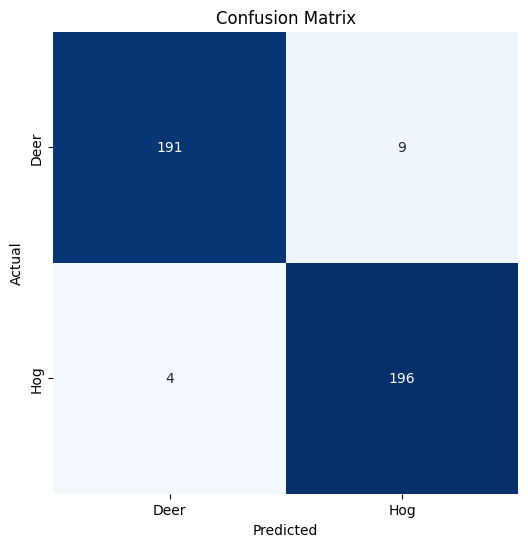

Classification Report:
----------------------
               precision    recall  f1-score   support

        Deer       0.98      0.95      0.97       200
         Hog       0.96      0.98      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [16]:
predictions = (model.predict(images_to_test) >= 0.5).astype(int)

cm = confusion_matrix(images_to_test.labels, predictions, labels=[0, 1])
clr = classification_report(images_to_test.labels, predictions, labels=[0, 1], target_names=["Deer", "Hog"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Deer", "Hog"])
plt.yticks(ticks=[0.5, 1.5], labels=["Deer", "Hog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### Class prediction on single images

In [17]:
model = load_model('/content/drive/MyDrive/AI_Capstone_2023/V7_model.h5')

In [34]:
image_path = '/content/drive/MyDrive/AI_Capstone_2023/pipeline_end_test/deer2.jpg'
input_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
height, width, _ = input_image.shape
#print(height, width)
original_scale = (width, height)

piped_image = cv2.resize(input_image, (224, 224))

In [35]:
piped_image_array = img_to_array(piped_image)
piped_image_array = np.expand_dims(piped_image_array, axis=0)

# Predict the class of the input image
prediction = model.predict(piped_image_array)
print(prediction)
formated_pred = np.format_float_positional(prediction[0][0], precision=50)
print(formated_pred)

1/1 [==============================] - 0s 19ms/step
[[0.]]
0.


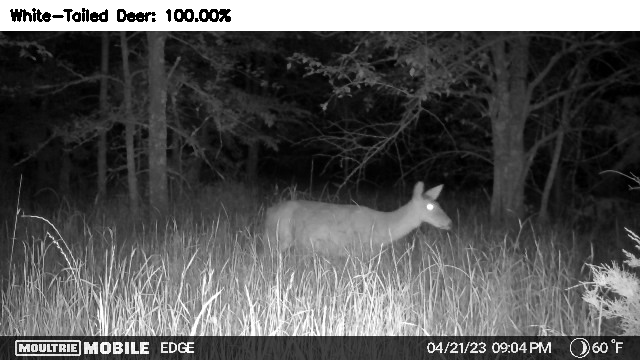

In [36]:
threshold = 0.5

# Check if the image belongs to either class
if prediction < threshold:
    class_name = "White-Tailed Deer"
    certainty = 100 - (prediction[0][0] * 100)
elif prediction >= threshold:
    class_name = "Wild Hog"
    certainty = prediction[0][0] * 100

# Display the class name and certainty
text = f"{class_name}: {certainty:.2f}%"
#output_image = cv2.resize(input_image, original_scale)
cv2.rectangle(input_image, (0, 0), (width, 30), (255, 255, 255), -1)
cv2.putText(input_image, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
#cv2.rectangle(input_image, (0, 0), (width, height), (0, 255, 0), 2)

cv2_imshow(input_image)